In [89]:
import os
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from PIL import Image
import cv2
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.image as mImg
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [90]:
test_path = './test'
ann_path = './result'

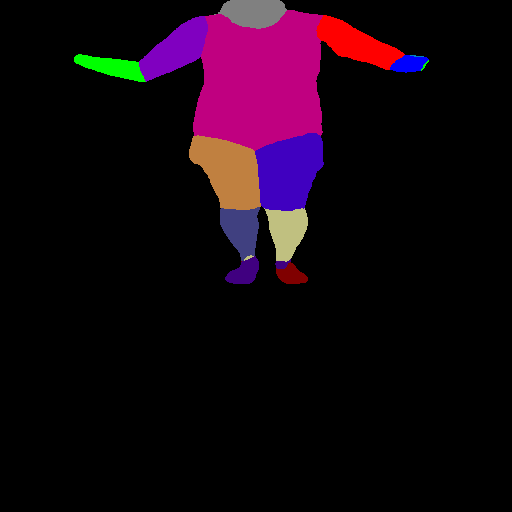

(262, (512, 512))

In [91]:
randnum = np.random.randint(0, 399)
image_sample = Image.open(os.path.join(ann_path, str(randnum).zfill(4)+'.png'))
image_sample.show()
randnum, image_sample.size

In [92]:
# 1 x 65536 -> 256 x 256
# list to image
# 그런데 result는 이미 image기 때문에 쓸 필요 없을듯..?
def decode(rle_mask):
    mask = rle_mask.split()
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)

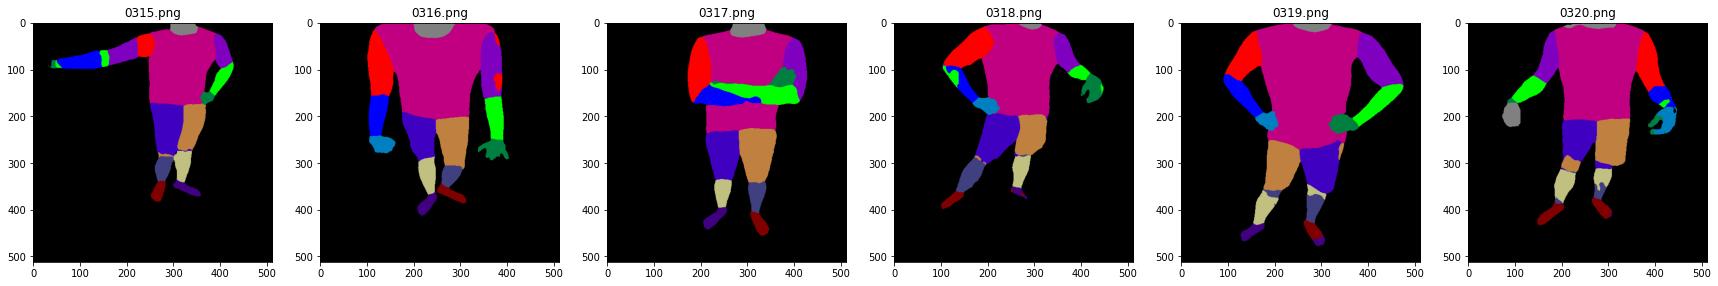

In [93]:
"""
reading and decoding the submission 

"""

j = np.random.randint(0, 394)
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..

# Visualizing the predicted outputs
for k in range(6):
    plt.subplot(1, 6, k+1)
    readImg = mImg.imread(os.path.join(ann_path, str(j+k).zfill(4)+'.png'))
    plt.imshow(readImg)
    plt.title(str(j+k).zfill(4)+'.png')


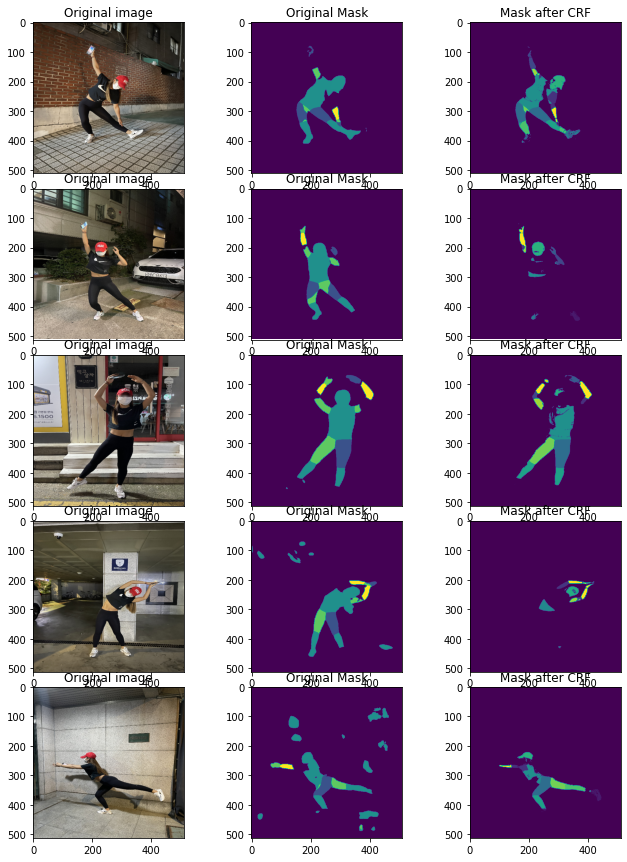

In [136]:
"""
visualizing the effect of applying CRF

"""
nImgs = 5
i = 5 # np.random.randint(399)
plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..

for j in range(1, nImgs+1):
    # # apply CRF
    img = imread(os.path.join(test_path, str(i+j).zfill(4)+'.jpg'))
    img = cv2.resize(img, (512, 512))
    anno_rgb = imread(os.path.join(ann_path, str(i+j).zfill(4)+'.png')).astype(np.uint32)
    anno_lbl = anno_rgb[:,:,0] + (anno_rgb[:,:,1] << 8) + (anno_rgb[:,:,2] << 16)

    colors, labels = np.unique(anno_lbl, return_inverse=True)
    # print(colors, len(colors)) # color 갯수 = label의 수
    # print(labels, len(labels)) # label 갯수 = 전체 픽셀 수 = 512*512

    # HAS_UNK = 0 in colors
    # if HAS_UNK:
    #     print("Found a full-black pixel in annotation image, assuming it means 'unknown' label, and will thus not be present in the output!")
    #     print("If 0 is an actual label for you, consider writing your own code, or simply giving your labels only non-zero values.")
    #     colors = colors[1:]

    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16

    n_labels = len(set(labels.flat)) #- int(HAS_UNK)
    # print(n_labels, " labels", (" plus \"unknown\" 0: " if HAS_UNK else ""), set(labels.flat))

    # Example using the DenseCRF2D code
    d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], n_labels)
    # print(img.shape)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=img,
                            compat=10,
                            kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(45)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    crf_output = MAP.reshape((img.shape[0],img.shape[1]))

    # show
    plt.subplot(nImgs,4,4*j-3)
    plt.imshow(img)
    plt.title('Original image')
    plt.subplot(nImgs,4,4*j-2)
    plt.imshow(anno_lbl) 
    plt.title('Original Mask')
    plt.subplot(nImgs,4,4*j-1)
    plt.imshow(crf_output) 
    plt.title('Mask after CRF')

In [22]:
"""
used for converting the decoded image to rle mask

"""
def encode(im):
    pixels = im.flatten()
    return ' '.join(str(x) for x in pixels)

In [23]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img = imread(test_path+df.loc[i,'image_id'])        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'PredictionString'] = encode(crf_output)

100%|██████████| 819/819 [14:23<00:00,  1.05s/it]


In [24]:
df.to_csv('./submission/crf_' + target_csv, index=False)